Introduction
--------------

The Fourier Transform is one of the most powerful and well known tools to analyse frequency behaviour. As such, it allows performing many operations in signal and imaging processing such as filtering, signal evaluation, signal characterization, etc.

In particular for medical applications some of the most widespread applications of Fourier Transform in signal processing are:
1. Filtering the signal to extract the information from the noise (i.e. the respiration rate will add important noise to an ECG signal but its frequency is much lower and can then be subtracted)
2. Evaluating the magnitude at specific frequencies of the signal to evaluate thresholds in an acquired signal (i.e. the detection of a seizure onset in EEG is characterized for large broadband signals)
3. The appearance of harmonics within a signal which may indicate there is an abnormality (i.e. the detection of harmonics in an ECG may indicate an arhytmia)

Fourier transforms present important properties that allow to combine analysis in frequency with simplicity:
1. Linearity: the transform of a sum is the sum of the transforms
2. Symmetry: the transform of the negative frequency is the conjugate of the transform
3. Convolution: the transform of a convolution is the product of each transform

In addition, filter design using frequency response is an important feature, and analysis of the response of a digital filter is usually done as a function of frequency:
1. It is often necessary to understand the behaviour of your signal before proposing the design of a filter
2. Once a filter is chosen, the impact of the order on the frequency behaviour of the filter and how that may affect the signal is important

The Discrete Fourier Transform (DFT) is the primary analysis tool for Fourier Transform nowadays since much of the processing is performed on digitized signals.

Using the DFT is equivalent to obtain a periodic signal out of a sequence (samples) of values.

This notebook will show how the DFT is implemented on a signal and how we can detect the presence and main frequency components of noise within the signal as well as the main frequency of the signal of interest.

We will work on an ultrasound signal that was acquired over time where some noise appears at some time point (we will determine when) and we will analyse the frequency component of the noise and the signal.

Some specifics about this acquired file: we obtained 15000 samples with a frequency of sampling of 125MHz, then waited another trigger and repeated for a total of 462 times.

We will also use this as an example on Python and simple signal analysis using Python.

We will start by opening the binary file where the signal was stored in unsigned integer (16 bits) and reading all the data into an array:



 The length of the file is: 6930000 as expected from 15000 samples x 462 lines

 The length of the time array is: 15000


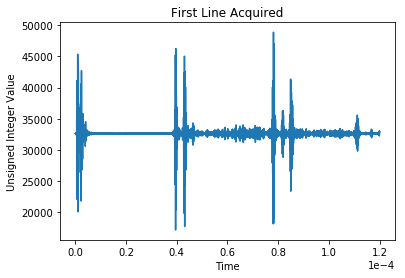

In [1]:
#we have first this command that initialize and matplotlib (library) for plotting and we specify that we want those plots inline in this notebook

# NOTE: IF YOU ARE EXECUTING FOR THE FIRST TIME RUN
%matplotlib inline
# IF YOU ARE EXECUTING FOR THE SECOND TIME IN INTERACTIVE MODE RUN
#%matplotlib nbagg

#now we import different packages that will allow to do math, lineal algebra, numerical operations, array operations and plotting
import scipy as Sci
import scipy.linalg
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

#we use a simple open command for the file (basic Python)
f = open('UltrasoundSampleSignal.dat','rb')
#we read it using a numpy (therefore the np.) command that allows direct reading from file into an array
AllSignal = np.fromfile(f,count=-1,dtype=np.uint16)
#to verify the size of the file I am printing here the lenght of that array 
print('\n The length of the file is: ' + str(len(AllSignal)) + ' as expected from 15000 samples x 462 lines')
#we will now populate an array for the time which we now is 1/125MHz step for a total of 15000
x=np.arange(0,15000/125e6,1/125e6)  #start,stop,step
print('\n The length of the time array is: ' + str(len(x)) )
#now we plot only the first line acquired (15000 samples)
plt.plot(x,AllSignal[:15000])
plt.title('First Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
f.close() #close the file


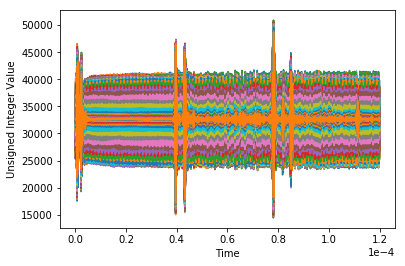

In [2]:
#We continue plotting other lines (we will plot every line and there are 462) 
totlines=np.arange(462)
for index in totlines:
    Signal=AllSignal[index*15000:(index+1)*15000]
    plt.plot(x,AllSignal[index*15000:(index+1)*15000])
    plt.xlabel('Time')
    plt.ylabel('Unsigned Integer Value')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

We can see from above that there are some lines that have noise.

We will first analyse the frequency component of a clean and a noisy line.

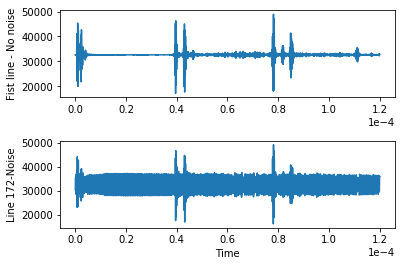

In [3]:
#The first line is clear
FirstLine=AllSignal[:15000]

#But some lines are very noisy, for instance line 172
NoisyLine=AllSignal[174*15000:(174+1)*15000]

plt.subplots_adjust( hspace = .5 )
plt.subplot(211)
plt.plot(x,FirstLine)
plt.ylabel('Fist line - No noise')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(212)
plt.plot(x,NoisyLine)
plt.xlabel('Time')
plt.ylabel('Line 172-Noise')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

Now that we have a noisy and a clean line we will obtain the frequency component of those signals using DFT.

First lets define the DFT:

$$ A_k=\sum_{m=0}^{n-1}a_m \exp \left(-2\pi i \frac{mk}{n} \right ) [k=0,...,n-1] $$

If we notice the signal has a dc component (not centered in zero) so unless we want to have a spectrum with a large value of dc or zero frequency we will first remove the dc component (by substracting the mean of the data).

We will then obtain the DFT.

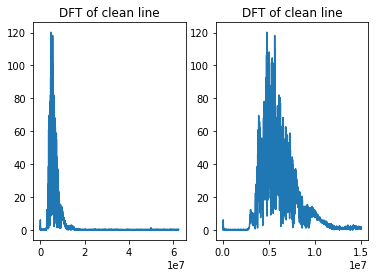

In [4]:
#we first eliminate dc
dataF=FirstLine-np.mean(FirstLine)
L=len(dataF)
#the frequencies after fft will be between 0 and 1/2 of the sampling frequency
f=np.arange(0,125e6/2,125e6/15000)
Y=np.fft.fft(dataF)
PyyClean=abs(Y)/L
#note: we are showing just L/2 elements which are the positive frequencies and we are normalizing
plt.subplot(121)
plt.plot(f, PyyClean[:7500])
plt.title('DFT of clean line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#Zooming into just less than 15MHz
inx=np.where(f>15e6)
inx=inx[0]
plt.subplot(122)
plt.plot(f[:inx[0]], PyyClean[:inx[0]])
plt.title('DFT of clean line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

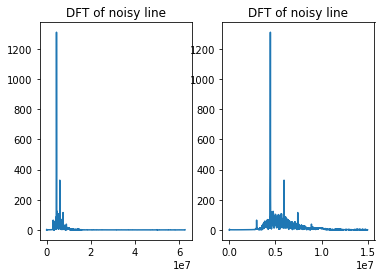

In [5]:
#now we repeat for the noisy line
#we first eliminate dc
dataN=NoisyLine-np.mean(NoisyLine)
L=len(dataN)
#the frequencies after fft will be between 0 and 1/2 of the sampling frequency
f=np.arange(0,125e6/2,125e6/15000)
Y=np.fft.fft(dataN)
PyyNoisy=abs(Y)/L
#note: we are showing just L/2 elements which are the positive frequencies and we are normalizing
plt.subplot(121)
plt.plot(f, PyyNoisy[:7500])
plt.title('DFT of noisy line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#Zooming into just less than 15MHz
inx=np.where(f>15e6)
inx=inx[0]
plt.subplot(122)
plt.plot(f[:inx[0]], PyyNoisy[:inx[0]])
plt.title('DFT of noisy line')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

We can clearly see there are large noise peaks at various frequencies. These are actually harmonics of 1.5MHz and it is strong at 4.5MHz.

We will use this here to determine a criteria for noise and later on to filter this signal.

A nice tool: let's use interactive graph to "see" where those peaks are. For this, the backend for matplotlib to use is called nbagg so we will change the inline magic for **nbagg**.

Go up in the code and change the magic command ```python %matplotlib inline``` for ```python %matplotlib nbagg``` and you will now be in **interactive mode**.

**BEFORE YOU RUN** select the option "Kernel->Restart" or the rendering will fail.


## Summary

In this example, we executed the Discrete Fourier Transform (DFT) on a clear and noisy signal.

Test your knowdelge:

Find which line(s) in the acquisition have a noticeable noise (we will define this point as when the noise peak at 4.5MHz reaches an amplitude in the FFT as high as the maximum in the clear line)
    1. Use a loop in the code
    2. Display all the line numbers that fall under this criteria
    3. Display the amplitude of the peak at 4.5MHz for each noisy line

Comments and corrections welcome!

References
---------------

* Oppenheim, A. V., and A. S. Willsky. "Signals and Systems." Prentice-Hall, (1997).